In [1]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import Model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
VGG=K.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [3]:
#VGG.summary()
poolindices=[3,6,11,16,21]

x=VGG.layers[0].output

VGG.layers[25].activation=None
for i in range(1,len(VGG.layers)):
    if i in poolindices:
        #print(VGG.layers[i].pool_size)
        x=K.layers.AveragePooling2D()(x)
    else:
        x=VGG.layers[i](x)
    VGG.layers[i].trainable=False

VGG = Model(inputs=VGG.layers[0].input, outputs=x)
VGG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
average_pooling2d_1 (Average (None, 56, 56, 128)       0     

In [4]:
VGG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
average_pooling2d_1 (Average (None, 56, 56, 128)       0     

In [5]:
outputs = [x.output for x in VGG.layers]
interVGG=tf.keras.Model([VGG.input], outputs)

In [61]:
psize=244
'''
im=Image.open('./deepstyle/lo.jpg')
im=np.array(im.resize((psize,psize))).astype(np.float32).reshape(1,psize,psize,3)
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(im)
pred=interVGG.predict(im)

plt.figure(figsize=(30,30))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(pred[1][:,:,:,i].reshape((244,244)))
plt.show()


layernum=19
filternum=50
targetact=pred[layernum][0][:,:,filternum].copy()*10
#whiteim=np.random.rand(1,psize,psize,3).astype(np.float32)
'''
im=Image.open('./deepstyle/hangya.jpg')
whiteim=np.array(im.resize((psize,psize))).astype(np.float32).reshape(1,psize,psize,3)[:,:,:,::-1]/255.0
#whiteim=np.random.rand(1,psize,psize,3).astype(np.float32)
img = tf.Variable(whiteim)
base_shape = tf.cast(tf.shape(img)[1:-1], tf.float32)

origvar=tf.reduce_sum(tf.image.total_variation(img))

In [66]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def contentloss(actlist,layeract):
    losses = []
    for act in actlist:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return  tf.reduce_sum(losses)-tf.reduce_sum(layeract)
   

layerlist=[25]
filterlist=np.arange(301,302).astype(np.int32)
stepsize=0.01
def contentopt(img,layerlist,filterlist,stepsize,origvar):
    with tf.GradientTape() as g:
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(img*255.0)
        pred=interVGG(preprocessed_input)
        actlist=[pred[x][0][filter] for filter in filterlist for x in layerlist] #[0][:,:,filter] for filter in filterlist
        loss=contentloss(actlist,pred[25])#-(tf.abs(tf.reduce_sum(tf.image.total_variation(img))-origvar))*0.0005
        
    
    #trainablevar=img
    gradients = g.gradient(loss,img)
    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    #print(gradients)
    img.assign(tf.clip_by_value(img+gradients*stepsize, 0, 1))
    #img = 
    print(loss)
    return img
    
    
OCTAVE_SCALE = 1.2





tf.Tensor(0.653331, shape=(), dtype=float32)
tf.Tensor(4.311527, shape=(), dtype=float32)
tf.Tensor(8.176613, shape=(), dtype=float32)
tf.Tensor(12.743061, shape=(), dtype=float32)
tf.Tensor(19.263874, shape=(), dtype=float32)
tf.Tensor(20.883211, shape=(), dtype=float32)
tf.Tensor(30.830639, shape=(), dtype=float32)
tf.Tensor(34.04834, shape=(), dtype=float32)
tf.Tensor(47.314922, shape=(), dtype=float32)
tf.Tensor(51.776737, shape=(), dtype=float32)
tf.Tensor(69.567184, shape=(), dtype=float32)
tf.Tensor(77.9293, shape=(), dtype=float32)
tf.Tensor(90.89821, shape=(), dtype=float32)
tf.Tensor(95.74074, shape=(), dtype=float32)
tf.Tensor(112.99999, shape=(), dtype=float32)
tf.Tensor(125.17723, shape=(), dtype=float32)
tf.Tensor(134.61288, shape=(), dtype=float32)
tf.Tensor(150.79945, shape=(), dtype=float32)
tf.Tensor(163.53717, shape=(), dtype=float32)
tf.Tensor(173.42479, shape=(), dtype=float32)
tf.Tensor(181.50874, shape=(), dtype=float32)
tf.Tensor(197.25398, shape=(), dtype=float

tf.Tensor(162.40158, shape=(), dtype=float32)
tf.Tensor(171.72104, shape=(), dtype=float32)
tf.Tensor(177.79318, shape=(), dtype=float32)
tf.Tensor(185.51083, shape=(), dtype=float32)
tf.Tensor(201.60492, shape=(), dtype=float32)
tf.Tensor(207.40302, shape=(), dtype=float32)
tf.Tensor(218.24207, shape=(), dtype=float32)
tf.Tensor(228.45518, shape=(), dtype=float32)
tf.Tensor(238.5435, shape=(), dtype=float32)
tf.Tensor(239.3483, shape=(), dtype=float32)
tf.Tensor(251.50108, shape=(), dtype=float32)
tf.Tensor(263.4355, shape=(), dtype=float32)
tf.Tensor(259.04813, shape=(), dtype=float32)
tf.Tensor(283.03217, shape=(), dtype=float32)
tf.Tensor(284.50015, shape=(), dtype=float32)
tf.Tensor(307.87085, shape=(), dtype=float32)
tf.Tensor(302.14374, shape=(), dtype=float32)
tf.Tensor(321.0082, shape=(), dtype=float32)
tf.Tensor(327.13806, shape=(), dtype=float32)
tf.Tensor(335.1339, shape=(), dtype=float32)


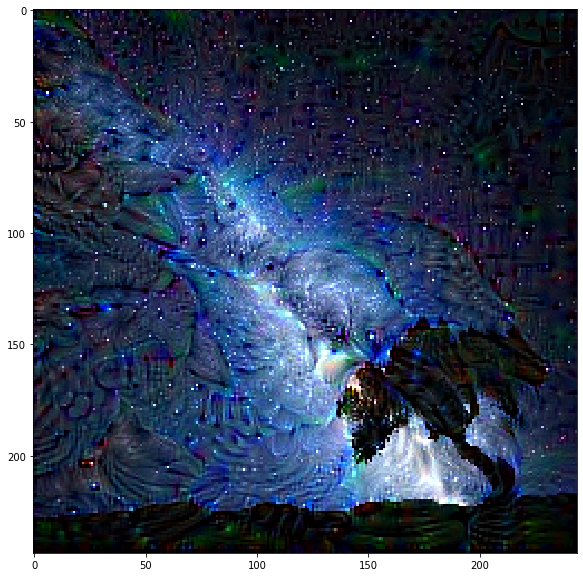

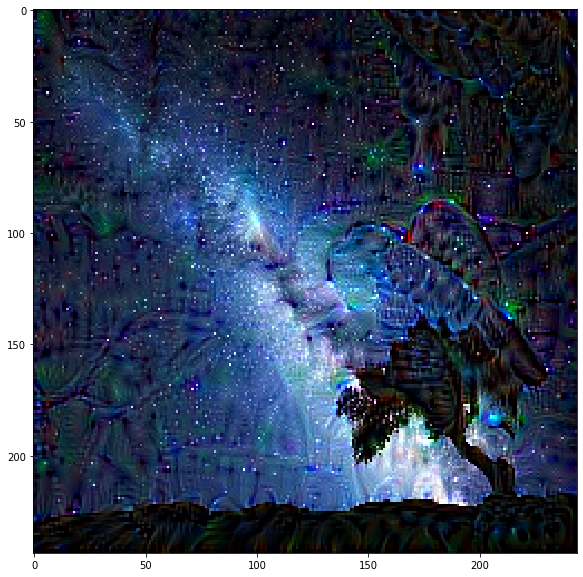

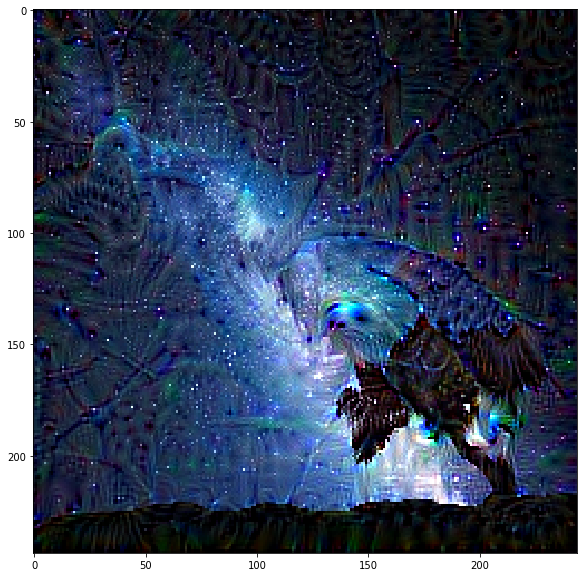

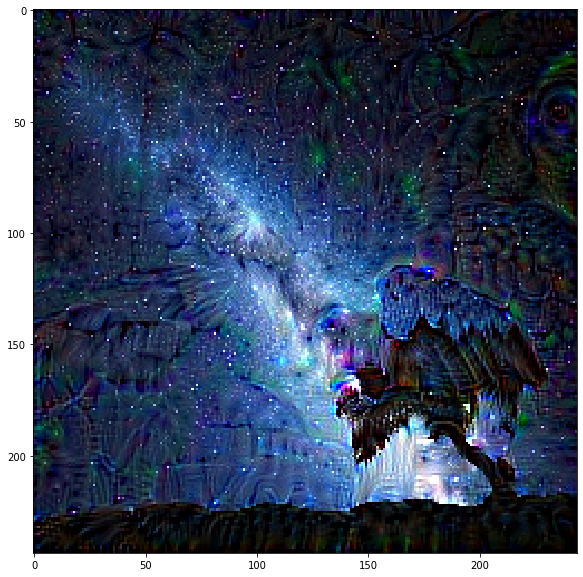

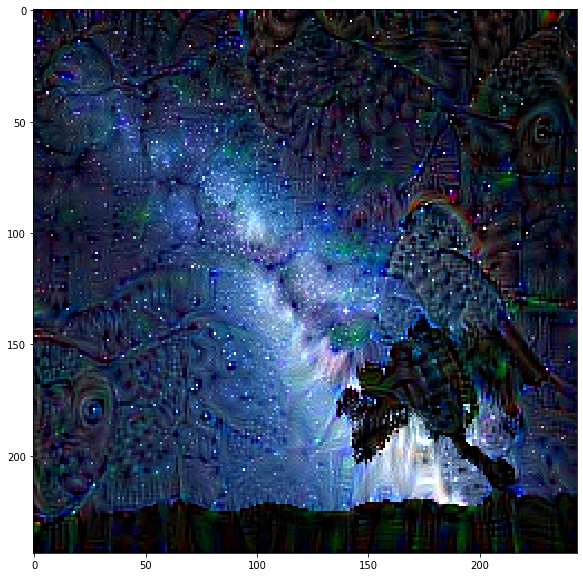

In [67]:
for i in range(20,25):
    im=Image.open('./deepstyle/ejszaka.jpg')
    whiteim=np.array(im.resize((psize,psize))).astype(np.float32).reshape(1,psize,psize,3)[:,:,:,::-1]/255.0
    img = tf.Variable(whiteim)
    base_shape = tf.cast(tf.shape(img)[1:-1], tf.float32) 
    filterlist=[i]
    for n in range(1):
        if n>-1:
            new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32)
            pdim=new_shape.numpy()[1]
            img =tf.Variable(tf.image.resize(img, new_shape).numpy())

            for i in range(40):
                cucc=contentopt(img,layerlist,filterlist,stepsize,origvar)
    img=tf.image.resize(img, tf.cast(base_shape,tf.int32))
    plt.figure(figsize=(10,10))
    plt.imshow(img.numpy().reshape(psize,psize,3)[:,:,::-1])
plt.show()
